<a href="https://colab.research.google.com/github/natanlubman/studies_ML/blob/main/HW_3_Natan(204811822)_Guy(308224948).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 – Aim: ANN from Scratch (40 Points)

1. Read chapter 11: “Implementing a Multi-layer Artificial Neural Network from Scratch” of the book “Machine Learning with PyTorch and Scikit-Learn” by Raschka et al. (2022)

2. Given the code of chapter 11 that can be found in:
https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.ipynb
your main goal is to extend the code to address two hidden layers (instead of a single hidden layer). Extend the code by creating a local copy of the ch11.
ipynb, perform the revisions, and submit the GitHub link to your revised code.


3. Apply the code of section 2 with the two layers for classifying handwritten digits MNIST dataset using the same full ANN architecture presented in the class (see “Solution 1: A plain deep NN”) and evaluate its prediction performance (macro AUC) using Train(70%)/Test(30%) validation procedure. 


In [ ]:
import os 
import random
import numpy as np 
import tensorflow as tf
import torch

def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    tf.random.set_seed(seed)    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)

## Load MNIST data

In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
X = ((X / 255.) - .5) * 2

y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size=0.3, 
                                                  random_state=123, 
                                                  stratify=y)

# optional to free up some memory by deleting non-used arrays:
del X, y

In [ ]:
NUM_FEATURES = 28 * 28
NUM_HIDDEN = 50
NUM_CLASSES = 10
NUM_EPOCHS = 50
BATCH_SIZE = 100
LR = 0.1

## Methods for training

In [ ]:
import numpy as np

def minibatch_generator(X, y, BATCH_SIZE):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - BATCH_SIZE + 1, BATCH_SIZE):
        batch_idx = indices[start_idx:start_idx + BATCH_SIZE]
        yield X[batch_idx], y[batch_idx]

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=BATCH_SIZE):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        probas = nnet.forward(features)[-1]
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
def sanity_check(model, X_valid, y_valid):
    probas = model.forward(X_valid)[-1]
    mse = mse_loss(y_valid, probas)

    predicted_labels = np.argmax(probas, axis=1)
    acc = accuracy(y_valid, predicted_labels)

    print(f'Initial validation MSE: {mse:.1f}')
    print(f'Initial validation accuracy: {acc*100:.1f}%')

In [ ]:
def train_single_layer(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, BATCH_SIZE)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc



def train_two_layers(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, BATCH_SIZE)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            (d_loss__d_w_out, d_loss__d_b_out, 
            d_loss__d_w_h1, d_loss__d_b_h1,
            d_loss__d_w_h2, d_loss__d_b_h2) = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [ ]:
import matplotlib.pyplot as plt
def plot_MSE(epoch_loss, title):
    plt.plot(range(len(epoch_loss)), epoch_loss)
    plt.ylabel('Mean squared error')
    plt.xlabel('Epoch')
    #plt.savefig('figures/11_07.png', dpi=300)
    plt.title(title)
    plt.show()

def plot_accuracy(epoch_train_acc, epoch_valid_acc, title):
    plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
            label='Training')
    plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
            label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()

## Model Implementation

In [ ]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

class TwoLayersMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h1 = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)

        self.weight_h2 = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
        loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)


    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Second Hidden Layer
        # input dim: [n_examples, n_hidden] dot [num_hidden2, n_hidden].T
        # output dim: [n_examples, num_hidden2]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, num_hidden2] dot [n_classes, num_hidden2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, num_hidden2]
        d_z_out__dw_out = a_h2

        # input dim: [n_examples, n_classes].T dot [n_examples, num_hidden2]
        # output dim: [n_classes, num_hidden2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################        
        # Part 2: dLoss/dHiddenWeights of layer h2
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, num_hidden2]
        d_z_out__d_a_h2 = self.weight_out

        # Input: [n_examples, n_classes] dot [n_classes, num_hidden2]
        # output dim: [n_examples, num_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__d_a_h2)

        # [n_examples, num_hidden2]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        # [n_examples, n_hidden]
        d_z_h2__d_w_h2 = a_h1

        # Input: [n_examples, num_hidden2] * [n_examples, num_hidden2]
        # output dim: [n_examples, num_hidden2]
        d_loss__d_z_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        # Input: [n_examples, num_hidden2].T dot [n_examples, n_hidden]
        # output dim: [num_hidden2, n_hidden]
        d_loss__d_w_h2 = np.dot(d_loss__d_z_h2.T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum(d_loss__d_z_h2, axis=0)

        #################################        
        # Part 2: dLoss/dHiddenWeights of layer h1
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [num_hidden2, n_hidden]
        d_z_h2__d_a_h1 = self.weight_h2

        # [n_examples, n_hidden]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative

        # Input: [n_examples, num_hidden2] @ [num_hidden2, n_hidden] * [n_examples, n_hidden]
        # output dim: [n_examples, n_hidden]
        d_loss__d_z_h1 = (d_loss__d_z_h2 @ d_z_h2__d_a_h1) * d_a_h1__d_z_h1
        
        # [n_examples, n_features]
        d_z_h1__d_w_h1 = x
        
        # Input dim: [n_examples, n_hidden].T dot [n_examples, n_features]
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h1 = np.dot(d_loss__d_z_h1.T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum(d_loss__d_z_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h1, d_loss__d_b_h1,
                d_loss__d_w_h2, d_loss__d_b_h2)

In [ ]:
two_layers_model = TwoLayersMLP(num_features=NUM_FEATURES,
                                num_hidden=NUM_HIDDEN,
                                num_classes=NUM_CLASSES)

sanity_check(two_layers_model, X_test, y_test)

Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train_two_layers(two_layers_model, 
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_epochs=NUM_EPOCHS, 
                                                                learning_rate=LR)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 21.29% | Valid Acc: 21.53%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 23.40% | Valid Acc: 23.33%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 33.60% | Valid Acc: 33.36%
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 59.08% | Valid Acc: 58.91%
Epoch: 005/050 | Train MSE: 0.05 | Train Acc: 66.51% | Valid Acc: 66.46%
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 77.70% | Valid Acc: 77.58%
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 83.58% | Valid Acc: 83.26%
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 86.68% | Valid Acc: 86.39%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 87.80% | Valid Acc: 87.67%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 88.56% | Valid Acc: 88.29%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 89.33% | Valid Acc: 88.99%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 89.81% | Valid Acc: 89.48%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 90.14% | Valid Acc: 89.74%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 90.57

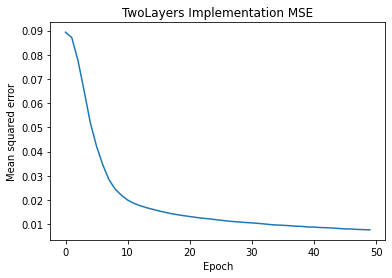

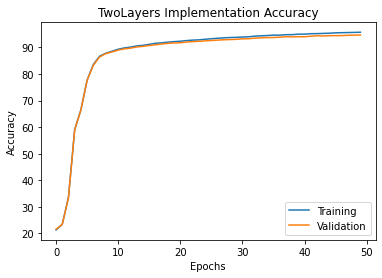

In [ ]:
plot_MSE(epoch_loss, "TwoLayers Implementation MSE")
plot_accuracy(epoch_train_acc, epoch_valid_acc, "TwoLayers Implementation Accuracy")

In [ ]:
test_mse, test_acc = compute_mse_and_acc(two_layers_model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.69%


## 2-layers MLP Evaluation
Apply the code of section 2 with the two layers for classifying handwritten digits MNIST dataset using the same full ANN architecture presented in the class (see “Solution 1: A plain deep NN”) and evaluate its prediction performance (macro AUC) using Train(70%)/Test(30%) validation procedure. 
Compare the predictive performance of section 3 with the original (single hidden layer) code and with the fully connected ANN implemented in Keras/TensorFlow/PyTorch (choose one).

## Original Single Layer Model from Git

In [ ]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
single_model = NeuralNetMLP(num_features=NUM_FEATURES,
                     num_hidden=NUM_HIDDEN,
                     num_classes=NUM_CLASSES)

sanity_check(single_model, X_test, y_test)

Initial validation MSE: 0.3
Initial validation accuracy: 9.2%


In [ ]:
epoch_loss, epoch_train_acc, epoch_valid_acc = train_single_layer(single_model, 
                                                                  X_train, y_train, 
                                                                  X_test, y_test, 
                                                                  num_epochs=NUM_EPOCHS, 
                                                                  learning_rate=LR)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 75.22% | Valid Acc: 75.13%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 84.59% | Valid Acc: 84.48%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 87.40% | Valid Acc: 87.31%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 88.87% | Valid Acc: 88.64%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 89.79% | Valid Acc: 89.58%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.37% | Valid Acc: 90.18%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 90.82% | Valid Acc: 90.66%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.21% | Valid Acc: 91.01%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 91.48% | Valid Acc: 91.32%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 91.72% | Valid Acc: 91.60%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 91.98% | Valid Acc: 91.80%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.12% | Valid Acc: 91.85%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.32% | Valid Acc: 92.07%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.52

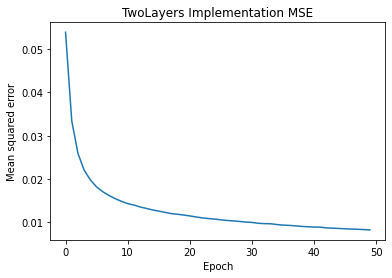

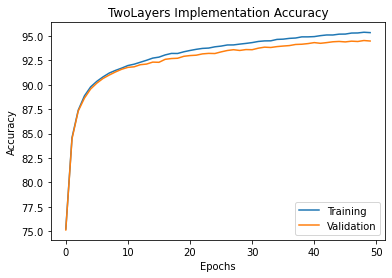

In [ ]:
plot_MSE(epoch_loss, "TwoLayers Implementation MSE")
plot_accuracy(epoch_train_acc, epoch_valid_acc, "TwoLayers Implementation Accuracy")

In [ ]:
test_mse, test_acc = compute_mse_and_acc(two_layers_model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.69%


## TF Two Layers MLP

In [ ]:
import tensorflow as tf
tf_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(NUM_FEATURES,)),
  tf.keras.layers.Dense(NUM_HIDDEN, activation='sigmoid'),
  tf.keras.layers.Dense(NUM_HIDDEN, activation='sigmoid'),
  tf.keras.layers.Dense(NUM_CLASSES)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

tf_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
              loss=loss_fn,
              metrics=['accuracy'])

tf_model.fit(X_train, y_train,
          validation_data=(X_test, y_test), 
          epochs=NUM_EPOCHS, 
          batch_size=BATCH_SIZE)

Epoch 1/50
490/490 [==============================] - 3s 5ms/step - loss: 1.5081 - accuracy: 0.6273 - val_loss: 0.7800 - val_accuracy: 0.8252
Epoch 2/50
490/490 [==============================] - 2s 5ms/step - loss: 0.5710 - accuracy: 0.8643 - val_loss: 0.4585 - val_accuracy: 0.8830
Epoch 3/50
490/490 [==============================] - 2s 4ms/step - loss: 0.4001 - accuracy: 0.8937 - val_loss: 0.3698 - val_accuracy: 0.9004
Epoch 4/50
490/490 [==============================] - 2s 4ms/step - loss: 0.3355 - accuracy: 0.9069 - val_loss: 0.3279 - val_accuracy: 0.9083
Epoch 5/50
490/490 [==============================] - 2s 4ms/step - loss: 0.2964 - accuracy: 0.9157 - val_loss: 0.2931 - val_accuracy: 0.9169
Epoch 6/50
490/490 [==============================] - 2s 4ms/step - loss: 0.2683 - accuracy: 0.9224 - val_loss: 0.2711 - val_accuracy: 0.9211
Epoch 7/50
490/490 [==============================] - 2s 4ms/step - loss: 0.2461 - accuracy: 0.9298 - val_loss: 0.2478 - val_accuracy: 0.9280
Epoch 

## Compare Models on Macro AUC

In [ ]:
import pandas as pd
def stable_softmax(X):
    exps = np.exp((X.T - np.max(X, axis=1)).T)
    return (exps.T / (np.sum(exps, axis=1))).T

In [ ]:
from sklearn.metrics import roc_auc_score
two_layers_pred = stable_softmax(two_layers_model.forward(X_test)[-1])
single_pred = stable_softmax(single_model.forward(X_test)[-1])
tf_pred = tf.keras.Sequential([tf_model, tf.keras.layers.Softmax()]).predict(X_test)

In [ ]:
two_auc = roc_auc_score(y_test, two_layers_pred, multi_class='ovr')
single_auc = roc_auc_score(y_test, single_pred, multi_class='ovr')
tf_auc = roc_auc_score(y_test, tf_pred, multi_class='ovr')
pd.DataFrame([two_auc, single_auc, tf_auc], index=['custom_two_layers', 'custom_single_layer', 'tf_two_layer'])

0
custom_two_layers    0.996590
custom_single_layer  0.996312
tf_two_layer         0.999011

# Part 2 (60 points) - Aim: Practice the usage of CNN (Convolutional Neural Network). 

## installation

In [ ]:
!pip install turicreate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.0 MB 24 kB/s 
     |████████████████████████████████| 3.5 MB 20.7 MB/s 
     |████████████████████████████████| 86.4 MB 79 kB/s 
     |████████████████████████████████| 322 kB 74.9 MB/s 
     |████████████████████████████████| 3.6 MB 27.0 MB/s 
     |████████████████████████████████| 18.3 MB 6.3 MB/s 
     |████████████████████████████████| 449 kB 73.6 MB/s 
     |████████████████████████████████| 20.1 MB 1.0 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 3.8 MB 57.6 MB/s 
     |████████████████████████████████| 2.9 MB 49.6 MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13714 sha256=c70158ced7c0a2d9f521fc01e06920d7088757e815936dcfb68ac79729b3de48
  Stored in directory: /root/.cache/pip/wheels/b2/7f/f6/f180315b584f00445045ff1699b550fa895d09471337ce21c6


In [ ]:
#!pip install autogluon

In [ ]:
exit()

## download data

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2022-07-10 06:20:45--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  11.8MB/s    in 30s     

2022-07-10 06:21:18 (10.9 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [ ]:
!mkdir flower_folder_

In [ ]:
!tar -xvf  '102flowers.tgz' -C 'flower_folder_'

Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

## 1.1 turicreate transfer learning

In [ ]:
import turicreate as tc

DATASET_PATH = "./flower_folder_/jpg"

all_data = tc.image_analysis.load_images(f"{DATASET_PATH}/", with_path=True)
all_data

Columns:
	path	str
	image	Image

Rows: 8189

Data:
+-------------------------------+------------------------+
|              path             |         image          |
+-------------------------------+------------------------+
| /content/flower_folder_/jp... | Height: 500 Width: 591 |
| /content/flower_folder_/jp... | Height: 500 Width: 625 |
| /content/flower_folder_/jp... | Height: 667 Width: 500 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
| /content/flower_folder_/jp... | Height: 500 Width: 508 |
| /content/flower_folder_/jp... | Height: 500 Width: 535 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
+-------------------------------+------------------------+
[8189 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2022-07-10 06:41:17--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat.1’

imagelabels.mat.1   100%[===================>]     502  --.-KB/s    in 0s      

2022-07-10 06:41:18 (151 MB/s) - ‘imagelabels.mat.1’ saved [502/502]



In [ ]:
import scipy.io
mat = scipy.io.loadmat('imagelabels.mat')

In [ ]:
labels = mat['labels'].T[:,0]

In [ ]:
all_data['class'] = list(labels)

In [ ]:
all_data['class'] = all_data['class'].apply(lambda x: int(x))

In [ ]:
# all_data.explore()

In [ ]:
train_data, test_data = all_data.random_split(0.75)
# train_data, validation_data = temp_data.random_split(0.66)

In [ ]:
??tc.image_classifier.create

In [ ]:
model = tc.image_classifier.create(train_data, target='class', max_iterations = 250, verbose=True, convergence_threshold= 0.0005)#, validation_set=test_data)

Performing feature extraction on resized images...
Completed   64/6197
Completed  128/6197
Completed  192/6197
Completed  256/6197
Completed  320/6197
Completed  384/6197
Completed  448/6197
Completed  512/6197
Completed  576/6197
Completed  640/6197
Completed  704/6197
Completed  768/6197
Completed  832/6197
Completed  896/6197
Completed  960/6197
Completed 1024/6197
Completed 1088/6197
Completed 1152/6197
Completed 1216/6197
Completed 1280/6197
Completed 1344/6197
Completed 1408/6197
Completed 1472/6197
Completed 1536/6197
Completed 1600/6197
Completed 1664/6197
Completed 1728/6197
Completed 1792/6197
Completed 1856/6197
Completed 1920/6197
Completed 1984/6197
Completed 2048/6197
Completed 2112/6197
Completed 2176/6197
Completed 2240/6197
Completed 2304/6197
Completed 2368/6197
Completed 2432/6197
Completed 2496/6197
Completed 2560/6197
Completed 2624/6197
Completed 2688/6197
Completed 2752/6197
Completed 2816/6197
Completed 2880/6197
Completed 2944/6197
Completed 3008/6197
Completed

Logistic regression:

--------------------------------------------------------

Number of examples          : 5887

Number of classes           : 102

Number of feature columns   : 1

Number of unpacked features : 2048

Number of coefficients      : 206949

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 2.793891     | 0.046373          | 0.038710            |

| 1         | 5        | 0.500000  | 5.451647     | 0.107695          | 0.132258            |

| 2         | 6        | 0.625000  | 7.156698     | 0.158485          | 0.180645            |

| 3         | 7        | 0.781250  | 8.891051     | 0.307797          | 0.300000            |

| 4         | 8        | 0.976563  | 10.589314    | 0.384916          | 0.341935            |

| 9         | 14       | 1.000000  | 19.983288    | 0.851198          | 0.780645            |

| 14        | 20       | 1.000000  | 29.374100    | 0.917105          | 0.829032            |

| 19        | 26       | 1.000000  | 38.773408    | 0.962799          | 0.858065            |

| 24        | 33       | 0.926804  | 49.417365    | 0.986071          | 0.867742            |

| 29        | 39       | 1.000000  | 58.968696    | 0.993545          | 0.887097            |

| 34        | 45       | 1.000000  | 68.523931    | 0.999830          | 0.880645            |

| 39        | 51       | 1.000000  | 77.978337    | 0.999830          | 0.890323            |

| 44        | 57       | 1.000000  | 87.640295    | 1.000000          | 0.890323            |

| 49        | 63       | 1.000000  | 97.165124    | 1.000000          | 0.893548            |

| 54        | 69       | 1.000000  | 106.947331   | 1.000000          | 0.890323            |

| 59        | 74       | 1.000000  | 115.444138   | 1.000000          | 0.900000            |

| 64        | 81       | 0.926843  | 125.751945   | 1.000000          | 0.906452            |

| 69        | 86       | 1.000000  | 134.353762   | 1.000000          | 0.903226            |

| 74        | 92       | 1.000000  | 143.948267   | 1.000000          | 0.903226            |

| 79        | 98       | 1.000000  | 153.552909   | 1.000000          | 0.912903            |

| 84        | 104      | 1.000000  | 163.064238   | 1.000000          | 0.916129            |

| 89        | 110      | 1.000000  | 172.539960   | 1.000000          | 0.903226            |

| 94        | 116      | 1.000000  | 182.026635   | 1.000000          | 0.906452            |

| 99        | 121      | 1.000000  | 190.485026   | 1.000000          | 0.916129            |

| 104       | 128      | 1.000000  | 200.738831   | 1.000000          | 0.912903            |

| 109       | 133      | 1.000000  | 209.284809   | 1.000000          | 0.909677            |

| 114       | 139      | 1.000000  | 218.999408   | 1.000000          | 0.909677            |

| 119       | 145      | 1.000000  | 228.398056   | 1.000000          | 0.912903            |

| 124       | 151      | 1.000000  | 237.839381   | 1.000000          | 0.912903            |

| 129       | 158      | 1.000000  | 248.298392   | 1.000000          | 0.912903            |

| 134       | 164      | 1.000000  | 257.883146   | 1.000000          | 0.912903            |

| 139       | 171      | 0.956868  | 268.183596   | 1.000000          | 0.912903            |

| 144       | 176      | 1.000000  | 276.777066   | 1.000000          | 0.912903            |

| 149       | 181      | 1.000000  | 285.448407   | 1.000000          | 0.912903            |

| 154       | 188      | 0.862688  | 295.847515   | 1.000000          | 0.912903            |

| 159       | 194      | 1.000000  | 305.433160   | 1.000000          | 0.912903            |

| 164       | 200      | 1.000000  | 314.837865   | 1.000000          | 0.912903            |

| 169       | 208      | 0.520610  | 326.360374   | 1.000000          | 0.912903            |

| 174       | 213      | 1.000000  | 334.844194   | 1.000000          | 0.909677            |

| 179       | 219      | 1.000000  | 344.506062   | 1.000000          | 0.912903            |

| 184       | 224      | 1.000000  | 353.276872   | 1.000000          | 0.909677            |

| 189       | 230      | 1.000000  | 362.830927   | 1.000000          | 0.909677            |

| 194       | 236      | 1.000000  | 372.312196   | 1.000000          | 0.909677            |

| 199       | 242      | 1.000000  | 381.903110   | 1.000000          | 0.909677            |

| 204       | 248      | 1.000000  | 391.640725   | 1.000000          | 0.909677            |

| 209       | 253      | 1.000000  | 400.219566   | 1.000000          | 0.909677            |

| 214       | 259      | 1.000000  | 409.718337   | 1.000000          | 0.909677            |

| 219       | 268      | 0.824251  | 421.927659   | 1.000000          | 0.912903            |

| 224       | 274      | 1.000000  | 431.529926   | 1.000000          | 0.912903            |

| 229       | 279      | 1.000000  | 440.237851   | 1.000000          | 0.912903            |

| 234       | 286      | 0.747063  | 450.533139   | 1.000000          | 0.912903            |

| 239       | 293      | 1.000000  | 460.877131   | 1.000000          | 0.912903            |

| 244       | 300      | 1.000000  | 471.339268   | 1.000000          | 0.912903            |

| 249       | 306      | 0.913686  | 481.078040   | 1.000000          | 0.912903            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [ ]:
test_data.materialize()
test_data['prediction'] = model.predict(test_data)
test_data

Columns:
	path	str
	image	Image
	class	int
	prediction	int

Rows: 1992

Data:
+-------------------------------+------------------------+-------+------------+
|              path             |         image          | class | prediction |
+-------------------------------+------------------------+-------+------------+
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 748 Width: 500 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 501 Width: 762 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 754 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 715 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 666 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
+-------------------------------+------------------------+-------+------------+
[1992 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
metrics = model.evaluate(test_data.sample(0.1))

Performing feature extraction on resized images...
Completed  64/205
Completed 128/205
Completed 192/205
Completed 205/205


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction']))

0.9307228915662651

In [ ]:
class_probability = model.predict_topk(test_data,k=2)
#class_probability.print_rows(num_rows=1000, num_columns=3) 

In [ ]:
class_probability = class_probability.sort([('id',True), ('probability',False)])

In [ ]:
test_data['prob_max'] = class_probability['probability'][::2]
test_data['prob_runnerup'] = class_probability['probability'][1::2]
test_data.print_rows(num_rows=2114,max_row_width=1000)

+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+
|              path             |          image          | class | prediction |       prob_max      |     prob_runnerup      |
+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+
| /content/flower_folder_/jp... |  Height: 500 Width: 667 |   77  |     77     |  0.9999843573109041 | 1.3165103275136812e-05 |
| /content/flower_folder_/jp... |  Height: 510 Width: 500 |   77  |     77     |  0.9999999962965833 | 3.0854437854204032e-09 |
| /content/flower_folder_/jp... |  Height: 748 Width: 500 |   77  |     77     |  0.9999366327441132 | 3.2725242171814214e-05 |
| /content/flower_folder_/jp... |  Height: 501 Width: 762 |   77  |     77     |  0.9998819615864833 |  6.59260011146166e-05  |
| /content/flower_folder_/jp... |  Height: 500 Width: 754 |   77  |     77     |  0.9999732335562193 | 2

## model 2.1

In [ ]:
model2 = tc.image_classifier.create(train_data, target='class', max_iterations = 350, verbose=True, convergence_threshold= 0.0001, model="squeezenet_v1.1")#,validation_set=validation_data

Performing feature extraction on resized images...
Completed   64/6197
Completed  128/6197
Completed  192/6197
Completed  256/6197
Completed  320/6197
Completed  384/6197
Completed  448/6197
Completed  512/6197
Completed  576/6197
Completed  640/6197
Completed  704/6197
Completed  768/6197
Completed  832/6197
Completed  896/6197
Completed  960/6197
Completed 1024/6197
Completed 1088/6197
Completed 1152/6197
Completed 1216/6197
Completed 1280/6197
Completed 1344/6197
Completed 1408/6197
Completed 1472/6197
Completed 1536/6197
Completed 1600/6197
Completed 1664/6197
Completed 1728/6197
Completed 1792/6197
Completed 1856/6197
Completed 1920/6197
Completed 1984/6197
Completed 2048/6197
Completed 2112/6197
Completed 2176/6197
Completed 2240/6197
Completed 2304/6197
Completed 2368/6197
Completed 2432/6197
Completed 2496/6197
Completed 2560/6197
Completed 2624/6197
Completed 2688/6197
Completed 2752/6197
Completed 2816/6197
Completed 2880/6197
Completed 2944/6197
Completed 3008/6197
Completed

Logistic regression:

--------------------------------------------------------

Number of examples          : 5887

Number of classes           : 102

Number of feature columns   : 1

Number of unpacked features : 1000

Number of coefficients      : 101101

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 1.282561     | 0.030236          | 0.045161            |

| 1         | 5        | 0.500000  | 2.530429     | 0.059793          | 0.070968            |

| 2         | 6        | 0.625000  | 3.388048     | 0.124002          | 0.135484            |

| 3         | 7        | 0.781250  | 4.219432     | 0.158485          | 0.151613            |

| 4         | 8        | 0.976563  | 5.066826     | 0.242908          | 0.235484            |

| 9         | 14       | 1.000000  | 9.797853     | 0.593681          | 0.570968            |

| 14        | 20       | 1.000000  | 14.475194    | 0.590454          | 0.558065            |

| 19        | 31       | 0.852987  | 21.284542    | 0.709190          | 0.654839            |

| 24        | 36       | 1.000000  | 25.528950    | 0.739426          | 0.693548            |

| 29        | 42       | 1.000000  | 30.197757    | 0.811789          | 0.732258            |

| 34        | 48       | 1.000000  | 34.806572    | 0.839477          | 0.761290            |

| 39        | 54       | 1.000000  | 39.428791    | 0.866485          | 0.790323            |

| 44        | 59       | 1.000000  | 43.632412    | 0.889078          | 0.809677            |

| 49        | 64       | 1.000000  | 47.779563    | 0.904535          | 0.812903            |

| 54        | 69       | 1.000000  | 51.946487    | 0.920163          | 0.838710            |

| 59        | 74       | 1.000000  | 56.058339    | 0.931374          | 0.851613            |

| 64        | 84       | 1.000000  | 62.227162    | 0.943944          | 0.848387            |

| 69        | 90       | 1.000000  | 66.775674    | 0.952777          | 0.854839            |

| 74        | 96       | 1.000000  | 71.319921    | 0.961271          | 0.864516            |

| 79        | 102      | 1.000000  | 75.852568    | 0.970953          | 0.854839            |

| 84        | 107      | 1.000000  | 79.989927    | 0.977917          | 0.854839            |

| 89        | 113      | 1.000000  | 84.513226    | 0.982674          | 0.880645            |

| 94        | 119      | 1.000000  | 89.030719    | 0.989129          | 0.880645            |

| 99        | 124      | 1.000000  | 93.213905    | 0.991846          | 0.883871            |

| 104       | 129      | 1.000000  | 97.363828    | 0.995244          | 0.867742            |

| 109       | 134      | 1.000000  | 101.557082   | 0.996603          | 0.880645            |

| 114       | 142      | 0.750190  | 106.957572   | 0.997792          | 0.880645            |

| 119       | 147      | 1.000000  | 111.098999   | 0.998981          | 0.887097            |

| 124       | 153      | 1.000000  | 115.687748   | 0.999321          | 0.870968            |

| 129       | 159      | 0.992859  | 120.290463   | 0.999830          | 0.880645            |

| 134       | 164      | 1.000000  | 124.432959   | 1.000000          | 0.883871            |

| 139       | 171      | 0.980414  | 129.405528   | 1.000000          | 0.896774            |

| 144       | 176      | 1.000000  | 133.591719   | 1.000000          | 0.896774            |

| 149       | 182      | 1.000000  | 138.126132   | 1.000000          | 0.890323            |

| 154       | 188      | 1.000000  | 142.667405   | 1.000000          | 0.896774            |

| 159       | 194      | 1.000000  | 147.219758   | 1.000000          | 0.883871            |

| 164       | 200      | 1.000000  | 151.767825   | 1.000000          | 0.880645            |

| 169       | 205      | 1.000000  | 155.918256   | 1.000000          | 0.890323            |

| 174       | 210      | 1.000000  | 160.052328   | 1.000000          | 0.887097            |

| 179       | 216      | 1.000000  | 164.887068   | 1.000000          | 0.887097            |

| 184       | 223      | 1.000000  | 169.878992   | 1.000000          | 0.880645            |

| 189       | 229      | 1.000000  | 174.453254   | 1.000000          | 0.880645            |

| 194       | 235      | 1.000000  | 179.032092   | 1.000000          | 0.874194            |

| 199       | 241      | 1.000000  | 183.566818   | 1.000000          | 0.880645            |

| 204       | 247      | 1.000000  | 188.152801   | 1.000000          | 0.874194            |

| 209       | 253      | 1.000000  | 192.733311   | 1.000000          | 0.883871            |

| 214       | 259      | 1.000000  | 197.321079   | 1.000000          | 0.887097            |

| 219       | 265      | 1.000000  | 201.889196   | 1.000000          | 0.883871            |

| 224       | 270      | 1.000000  | 206.071320   | 1.000000          | 0.909677            |

| 229       | 277      | 1.000000  | 211.105741   | 1.000000          | 0.900000            |

| 234       | 283      | 1.000000  | 215.693303   | 1.000000          | 0.900000            |

| 239       | 289      | 1.000000  | 220.237712   | 1.000000          | 0.900000            |

| 244       | 294      | 1.000000  | 224.372733   | 1.000000          | 0.896774            |

| 249       | 300      | 1.000000  | 228.962287   | 1.000000          | 0.896774            |

| 254       | 305      | 1.000000  | 233.086000   | 1.000000          | 0.896774            |

| 259       | 311      | 1.000000  | 237.670835   | 1.000000          | 0.896774            |

| 264       | 317      | 0.978909  | 242.159074   | 1.000000          | 0.900000            |

| 269       | 323      | 1.000000  | 246.696524   | 1.000000          | 0.890323            |

| 274       | 329      | 1.000000  | 251.285532   | 1.000000          | 0.900000            |

| 279       | 335      | 1.000000  | 255.809443   | 1.000000          | 0.900000            |

| 284       | 341      | 1.000000  | 260.353038   | 1.000000          | 0.900000            |

| 289       | 346      | 1.000000  | 264.512295   | 1.000000          | 0.906452            |

| 294       | 353      | 1.000000  | 269.450940   | 1.000000          | 0.909677            |

| 299       | 359      | 1.000000  | 274.072094   | 1.000000          | 0.906452            |

| 304       | 367      | 1.000000  | 279.428625   | 1.000000          | 0.903226            |

| 309       | 372      | 1.000000  | 283.580414   | 1.000000          | 0.903226            |

| 314       | 379      | 1.000000  | 288.537122   | 1.000000          | 0.903226            |

| 319       | 387      | 1.000000  | 293.955598   | 1.000000          | 0.906452            |

| 324       | 393      | 1.000000  | 298.541811   | 1.000000          | 0.906452            |

| 329       | 399      | 1.000000  | 303.171992   | 1.000000          | 0.900000            |

| 334       | 404      | 1.000000  | 307.337289   | 1.000000          | 0.906452            |

| 339       | 411      | 0.978068  | 312.277950   | 1.000000          | 0.900000            |

| 344       | 417      | 0.680436  | 316.803293   | 1.000000          | 0.903226            |

| 349       | 423      | 0.980771  | 321.366107   | 1.000000          | 0.906452            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [ ]:
test_data.materialize()
test_data['prediction2'] = model2.predict(test_data)
test_data

Columns:
	path	str
	image	Image
	class	int
	prediction	int
	prob_max	float
	prob_runnerup	float
	prediction2	int
	prob_max2	float
	prob_runnerup2	float
	flag	int
	prediction_final	int

Rows: 1992

Data:
+-------------------------------+------------------------+-------+------------+
|              path             |         image          | class | prediction |
+-------------------------------+------------------------+-------+------------+
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 748 Width: 500 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 501 Width: 762 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 754 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 715 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 666 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
+-------------------------------+------------------------+-------+------------+
+--------------------+------------------------+-------------+--------------------+
|      prob_max      |     prob_runnerup      | prediction2 |     prob_max2      |
+--------------------+------------------------+-------------+--------------------+
| 0.9999843573109041 | 1.3165103275136812e-05 |      77     | 0.9998056172983727 |
| 0.9999999962965833 | 3.0854437854204032e-09 |      77     | 0.9999156859325325 |
| 0.9999366327441132 | 3.2725242171814214e-05 |      77     | 0.7340896748864197 |
| 0.9998819615864833 |  6.59260011146166e-05  |      77     | 0.9999783405778254 |
| 0.9999732335562193 | 2.1576257106169713e-05 |      77     | 0.9034544785819283 |
| 0.8781577946537179 |  0.11248919058250896   |      77     | 0.9999752512466992 |
| 0.9999889873488482 | 3.579038369254025e-06  |      77     | 0.9999898689247494 |
| 0.9999717269154361 | 1.4602450141383153e-05 |      77     | 0.9998862456184034 |
| 0.9999497304491622 | 1.081380272927203e-05  |      77     | 0.9999998953511803 |
| 0.9999999999996279 | 3.0967765649706716e-13 |      77     | 0.993513494248353  |
+--------------------+------------------------+-------------+--------------------+
+------------------------+------+------------------+
|     prob_runnerup2     | flag | prediction_final |
+------------------------+------+------------------+
| 0.00017748162762614764 |  0   |        77        |
| 4.622325361983716e-05  |  0   |        77        |
|   0.129561721502197    |  0   |        77        |
| 2.0492210880816447e-05 |  0   |        77        |
|  0.09175889208445304   |  0   |        77        |
| 2.4600522465330156e-05 |  1   |        77        |
|  8.23770557493765e-06  |  0   |        77        |
| 5.123782014176332e-05  |  0   |        77        |
| 6.877119654740482e-08  |  0   |        77        |
| 0.0036998224099874665  |  0   |        77        |
+------------------------+------+------------------+
[1992 rows x 11 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction2']))

0.8800200803212851

In [ ]:
class_probability = model2.predict_topk(test_data,k=2)
class_probability = class_probability.sort([('id',True), ('probability',False)])

In [ ]:
test_data['prob_max2'] = class_probability['probability'][::2]
test_data['prob_runnerup2'] = class_probability['probability'][1::2]
test_data.print_rows(num_rows=2114,max_row_width=1000)

+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+------+------------------+
|              path             |          image          | class | prediction |       prob_max      |     prob_runnerup      | prediction2 |      prob_max2      |     prob_runnerup2     | flag | prediction_final |
+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+------+------------------+
| /content/flower_folder_/jp... |  Height: 500 Width: 667 |   77  |     77     |  0.9999843573109041 | 1.3165103275136812e-05 |      77     |  0.9993285951074916 | 0.0006338985048860743  |  0   |        77        |
| /content/flower_folder_/jp... |  Height: 510 Width: 500 |   77  |     77     |  0.9999999962965833 | 3.0854437854204032e-09 |      77     

In [ ]:
option_1 = (test_data['prob_max'] < 0.97) & (test_data['prob_max2'] > 0.97)
option_2 = (test_data['prob_max'] < 0.95) & (test_data['prob_max2'] > 0.95)
option_3 = (test_data['prob_max'] < 0.8) & (test_data['prob_max2'] > 0.8)
option_4 = (test_data['prob_max'] < 0.55) 
all_options = option_1 | option_2 | option_3| option_4

test_data['flag'] = all_options
test_data['prediction_final'] = test_data['prediction'] * -1 * (test_data['flag'] - 1) + test_data['prediction2'] * test_data['flag']


In [ ]:
test_data.print_rows(num_rows=2114,max_row_width=1000)

+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+------+------------------+
|              path             |          image          | class | prediction |       prob_max      |     prob_runnerup      | prediction2 |      prob_max2      |     prob_runnerup2     | flag | prediction_final |
+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+------+------------------+
| /content/flower_folder_/jp... |  Height: 500 Width: 667 |   77  |     77     |  0.9999843573109041 | 1.3165103275136812e-05 |      77     |  0.9993285951074916 | 0.0006338985048860743  |  0   |        77        |
| /content/flower_folder_/jp... |  Height: 510 Width: 500 |   77  |     77     |  0.9999999962965833 | 3.0854437854204032e-09 |      77     

In [ ]:
accuracy_score(list(test_data['class']), list(test_data['prediction_final']))

0.9357429718875502

## 1.2 turicreate transfer learning

In [ ]:
import turicreate as tc

DATASET_PATH = "./flower_folder_/jpg"

all_data = tc.image_analysis.load_images(f"{DATASET_PATH}/", with_path=True)
all_data

Columns:
	path	str
	image	Image

Rows: 8189

Data:
+-------------------------------+------------------------+
|              path             |         image          |
+-------------------------------+------------------------+
| /content/flower_folder_/jp... | Height: 500 Width: 591 |
| /content/flower_folder_/jp... | Height: 500 Width: 625 |
| /content/flower_folder_/jp... | Height: 667 Width: 500 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
| /content/flower_folder_/jp... | Height: 500 Width: 508 |
| /content/flower_folder_/jp... | Height: 500 Width: 535 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |
+-------------------------------+------------------------+
[8189 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2022-07-09 21:59:52--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat.4’

imagelabels.mat.4   100%[===================>]     502  --.-KB/s    in 0s      

2022-07-09 21:59:54 (142 MB/s) - ‘imagelabels.mat.4’ saved [502/502]



In [ ]:
import scipy.io
mat = scipy.io.loadmat('imagelabels.mat')

In [ ]:
labels = mat['labels'].T[:,0]

In [ ]:
all_data['class'] = list(labels)

In [ ]:
all_data['class'] = all_data['class'].apply(lambda x: int(x))

In [ ]:
# all_data.explore()

In [ ]:
train_data, test_data = all_data.random_split(0.75)
# train_data, validation_data = temp_data.random_split(0.66)

In [ ]:
model = tc.image_classifier.create(train_data, target='class', max_iterations = 250, verbose=True, convergence_threshold= 0.0005)#, validation_set=test_data)

Performing feature extraction on resized images...
Completed   64/6207
Completed  128/6207
Completed  192/6207
Completed  256/6207
Completed  320/6207
Completed  384/6207
Completed  448/6207
Completed  512/6207
Completed  576/6207
Completed  640/6207
Completed  704/6207
Completed  768/6207
Completed  832/6207
Completed  896/6207
Completed  960/6207
Completed 1024/6207
Completed 1088/6207
Completed 1152/6207
Completed 1216/6207
Completed 1280/6207
Completed 1344/6207
Completed 1408/6207
Completed 1472/6207
Completed 1536/6207
Completed 1600/6207
Completed 1664/6207
Completed 1728/6207
Completed 1792/6207
Completed 1856/6207
Completed 1920/6207
Completed 1984/6207
Completed 2048/6207
Completed 2112/6207
Completed 2176/6207
Completed 2240/6207
Completed 2304/6207
Completed 2368/6207
Completed 2432/6207
Completed 2496/6207
Completed 2560/6207
Completed 2624/6207
Completed 2688/6207
Completed 2752/6207
Completed 2816/6207
Completed 2880/6207
Completed 2944/6207
Completed 3008/6207
Completed

Logistic regression:

--------------------------------------------------------

Number of examples          : 5896

Number of classes           : 102

Number of feature columns   : 1

Number of unpacked features : 2048

Number of coefficients      : 206949

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 3.955284     | 0.059871          | 0.086817            |

| 1         | 5        | 0.500000  | 6.745463     | 0.155529          | 0.151125            |

| 2         | 6        | 0.625000  | 8.611156     | 0.256106          | 0.234727            |

| 3         | 7        | 0.781250  | 10.433991    | 0.364484          | 0.347267            |

| 4         | 8        | 0.976563  | 12.309343    | 0.451153          | 0.437299            |

| 9         | 13       | 1.000000  | 21.623906    | 0.863128          | 0.855305            |

| 14        | 18       | 1.000000  | 30.867613    | 0.929104          | 0.897106            |

| 19        | 23       | 1.000000  | 40.116852    | 0.974729          | 0.900322            |

| 24        | 29       | 1.000000  | 50.348113    | 0.989824          | 0.887460            |

| 29        | 35       | 1.000000  | 60.657559    | 0.999322          | 0.903537            |

| 34        | 40       | 1.000000  | 69.926366    | 0.999830          | 0.903537            |

| 39        | 46       | 1.000000  | 80.427267    | 1.000000          | 0.909968            |

| 44        | 53       | 1.000000  | 92.340161    | 1.000000          | 0.916399            |

| 49        | 59       | 1.000000  | 102.463925   | 1.000000          | 0.913183            |

| 54        | 65       | 1.000000  | 112.676493   | 1.000000          | 0.909968            |

| 59        | 71       | 1.000000  | 122.866023   | 1.000000          | 0.935691            |

| 64        | 76       | 1.000000  | 132.136982   | 1.000000          | 0.932476            |

| 69        | 81       | 1.000000  | 141.434539   | 1.000000          | 0.932476            |

| 74        | 87       | 1.000000  | 151.769047   | 1.000000          | 0.926045            |

| 79        | 94       | 1.000000  | 162.931264   | 1.000000          | 0.926045            |

| 84        | 100      | 1.000000  | 173.266677   | 1.000000          | 0.926045            |

| 89        | 106      | 1.000000  | 183.585552   | 1.000000          | 0.932476            |

| 94        | 112      | 1.000000  | 193.907497   | 1.000000          | 0.922830            |

| 99        | 118      | 1.000000  | 204.242158   | 1.000000          | 0.926045            |

| 104       | 123      | 1.000000  | 213.503706   | 1.000000          | 0.926045            |

| 109       | 132      | 0.743160  | 226.706681   | 1.000000          | 0.929260            |

| 114       | 138      | 1.000000  | 236.980069   | 1.000000          | 0.922830            |

| 119       | 144      | 1.000000  | 247.282804   | 1.000000          | 0.919614            |

| 124       | 152      | 0.707004  | 259.596173   | 1.000000          | 0.919614            |

| 129       | 158      | 1.000000  | 270.144807   | 1.000000          | 0.922830            |

| 134       | 163      | 1.000000  | 279.340648   | 1.000000          | 0.916399            |

| 139       | 175      | 2.322805  | 296.041121   | 1.000000          | 0.919614            |

| 144       | 190      | 1.016351  | 315.383613   | 1.000000          | 0.919614            |

| 149       | 199      | 1.000000  | 328.607517   | 1.000000          | 0.919614            |

| 154       | 213      | 1.000000  | 346.602060   | 1.000000          | 0.919614            |

| 159       | 219      | 1.000000  | 356.885016   | 1.000000          | 0.919614            |

| 164       | 226      | 0.967044  | 368.026598   | 1.000000          | 0.919614            |

| 169       | 233      | 1.000000  | 379.343182   | 1.000000          | 0.916399            |

| 174       | 239      | 1.000000  | 389.686817   | 1.000000          | 0.919614            |

| 179       | 245      | 1.000000  | 400.021239   | 1.000000          | 0.919614            |

| 184       | 251      | 1.000000  | 410.346500   | 1.000000          | 0.922830            |

| 189       | 263      | 1.044446  | 426.464685   | 1.000000          | 0.922830            |

| 194       | 268      | 1.044446  | 435.779651   | 1.000000          | 0.922830            |

| 199       | 281      | 1.160476  | 452.906955   | 1.000000          | 0.922830            |

| 204       | 288      | 1.000000  | 464.264266   | 1.000000          | 0.922830            |

| 209       | 299      | 1.000000  | 479.527571   | 1.000000          | 0.922830            |

| 214       | 307      | 1.000000  | 491.790655   | 1.000000          | 0.922830            |

| 219       | 312      | 1.000000  | 501.108813   | 1.000000          | 0.922830            |

| 224       | 319      | 1.000000  | 512.296683   | 1.000000          | 0.922830            |

| 229       | 324      | 1.000000  | 521.545525   | 1.000000          | 0.922830            |

| 234       | 330      | 1.000000  | 531.660366   | 1.000000          | 0.922830            |

| 239       | 337      | 1.000000  | 543.368265   | 1.000000          | 0.922830            |

| 244       | 346      | 0.924507  | 556.753246   | 1.000000          | 0.922830            |

| 249       | 353      | 1.000000  | 567.908081   | 1.000000          | 0.922830            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [ ]:
test_data.materialize()
test_data['prediction'] = model.predict(test_data)
test_data

Columns:
	path	str
	image	Image
	class	int
	prediction	int

Rows: 1982

Data:
+-------------------------------+------------------------+-------+------------+
|              path             |         image          | class | prediction |
+-------------------------------+------------------------+-------+------------+
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 666 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 645 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 755 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 751 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 754 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 715 |   77  |     77     |
+-------------------------------+------------------------+-------+------------+
[1982 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
metrics = model.evaluate(test_data.sample(0.1))

Performing feature extraction on resized images...
Completed  64/168
Completed 128/168
Completed 168/168


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction']))

0.920787083753784

In [ ]:
class_probability = model.predict_topk(test_data,k=2)
#class_probability.print_rows(num_rows=1000, num_columns=3) 

In [ ]:
class_probability = class_probability.sort([('id',True), ('probability',False)])

In [ ]:
test_data['prob_max'] = class_probability['probability'][::2]
test_data['prob_runnerup'] = class_probability['probability'][1::2]
test_data.print_rows(num_rows=2114,max_row_width=1000)

+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+
|              path             |          image          | class | prediction |       prob_max      |     prob_runnerup      |
+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+
| /content/flower_folder_/jp... |  Height: 500 Width: 667 |   77  |     77     |  0.9999122509879445 | 2.8078464540160097e-05 |
| /content/flower_folder_/jp... |  Height: 510 Width: 500 |   77  |     77     |  0.999999953297385  | 4.570023926045974e-08  |
| /content/flower_folder_/jp... |  Height: 500 Width: 666 |   77  |     77     |  0.9999984531324146 | 3.9438843205619233e-07 |
| /content/flower_folder_/jp... |  Height: 500 Width: 645 |   77  |     77     |  0.9999916607751641 | 7.406356179801769e-06  |
| /content/flower_folder_/jp... |  Height: 500 Width: 755 |   77  |     77     |  0.9999999941456387 | 4

## model 2.2

In [ ]:
model2 = tc.image_classifier.create(train_data, target='class', max_iterations = 500, verbose=True, convergence_threshold= 0.0001, model="squeezenet_v1.1")#,validation_set=validation_data

Performing feature extraction on resized images...
Completed   64/6207
Completed  128/6207
Completed  192/6207
Completed  256/6207
Completed  320/6207
Completed  384/6207
Completed  448/6207
Completed  512/6207
Completed  576/6207
Completed  640/6207
Completed  704/6207
Completed  768/6207
Completed  832/6207
Completed  896/6207
Completed  960/6207
Completed 1024/6207
Completed 1088/6207
Completed 1152/6207
Completed 1216/6207
Completed 1280/6207
Completed 1344/6207
Completed 1408/6207
Completed 1472/6207
Completed 1536/6207
Completed 1600/6207
Completed 1664/6207
Completed 1728/6207
Completed 1792/6207
Completed 1856/6207
Completed 1920/6207
Completed 1984/6207
Completed 2048/6207
Completed 2112/6207
Completed 2176/6207
Completed 2240/6207
Completed 2304/6207
Completed 2368/6207
Completed 2432/6207
Completed 2496/6207
Completed 2560/6207
Completed 2624/6207
Completed 2688/6207
Completed 2752/6207
Completed 2816/6207
Completed 2880/6207
Completed 2944/6207
Completed 3008/6207
Completed

Logistic regression:

--------------------------------------------------------

Number of examples          : 5896

Number of classes           : 102

Number of feature columns   : 1

Number of unpacked features : 1000

Number of coefficients      : 101101

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 1.323870     | 0.051900          | 0.051447            |

| 1         | 5        | 0.500000  | 2.673745     | 0.083955          | 0.083601            |

| 2         | 6        | 0.625000  | 3.533345     | 0.152476          | 0.157556            |

| 3         | 7        | 0.781250  | 4.417663     | 0.174864          | 0.176849            |

| 4         | 8        | 0.976563  | 5.297328     | 0.252205          | 0.270096            |

| 9         | 15       | 0.878275  | 10.604195    | 0.556309          | 0.565916            |

| 14        | 20       | 1.000000  | 15.007446    | 0.668758          | 0.688103            |

| 19        | 26       | 0.859963  | 19.833221    | 0.714891          | 0.723473            |

| 24        | 31       | 1.000000  | 24.248666    | 0.780868          | 0.771704            |

| 29        | 36       | 1.000000  | 28.674443    | 0.819030          | 0.797428            |

| 34        | 44       | 1.000000  | 34.363111    | 0.863806          | 0.836013            |

| 39        | 50       | 1.000000  | 39.228639    | 0.886703          | 0.861736            |

| 44        | 55       | 1.000000  | 43.668789    | 0.896710          | 0.861736            |

| 49        | 62       | 1.000000  | 48.978211    | 0.923338          | 0.868167            |

| 54        | 67       | 1.000000  | 53.374427    | 0.932836          | 0.906752            |

| 59        | 73       | 1.000000  | 58.215812    | 0.950645          | 0.903537            |

| 64        | 78       | 1.000000  | 63.511709    | 0.955563          | 0.903537            |

| 69        | 83       | 1.000000  | 68.017575    | 0.967436          | 0.909968            |

| 74        | 88       | 1.000000  | 72.448757    | 0.972863          | 0.900322            |

| 79        | 98       | 1.000000  | 79.699933    | 0.983209          | 0.903537            |

| 84        | 104      | 1.000000  | 84.598966    | 0.989484          | 0.900322            |

| 89        | 109      | 1.000000  | 89.044950    | 0.994742          | 0.906752            |

| 94        | 114      | 1.000000  | 93.482348    | 0.997795          | 0.903537            |

| 99        | 119      | 1.000000  | 97.956161    | 0.997965          | 0.906752            |

| 104       | 125      | 1.000000  | 102.858905   | 0.999491          | 0.913183            |

| 109       | 131      | 1.000000  | 107.782559   | 0.999491          | 0.909968            |

| 114       | 136      | 1.000000  | 112.259591   | 0.999830          | 0.913183            |

| 119       | 143      | 1.000000  | 117.497026   | 0.999830          | 0.913183            |

| 124       | 149      | 1.000000  | 122.539040   | 0.999830          | 0.916399            |

| 129       | 155      | 1.000000  | 127.326205   | 1.000000          | 0.913183            |

| 134       | 161      | 1.000000  | 132.175112   | 0.999830          | 0.909968            |

| 139       | 167      | 1.000000  | 137.042523   | 1.000000          | 0.906752            |

| 144       | 172      | 1.000000  | 141.487175   | 1.000000          | 0.909968            |

| 149       | 179      | 1.000000  | 146.830855   | 1.000000          | 0.906752            |

| 154       | 185      | 1.000000  | 151.740420   | 1.000000          | 0.909968            |

| 159       | 190      | 1.000000  | 156.165058   | 1.000000          | 0.909968            |

| 164       | 196      | 1.000000  | 161.043324   | 1.000000          | 0.913183            |

| 169       | 202      | 1.000000  | 165.953029   | 1.000000          | 0.909968            |

| 174       | 209      | 1.000000  | 171.293988   | 1.000000          | 0.913183            |

| 179       | 214      | 1.000000  | 175.807339   | 1.000000          | 0.909968            |

| 184       | 219      | 1.000000  | 180.313885   | 1.000000          | 0.906752            |

| 189       | 227      | 0.721054  | 186.074149   | 1.000000          | 0.903537            |

| 194       | 233      | 0.978024  | 190.957970   | 1.000000          | 0.903537            |

| 199       | 239      | 1.000000  | 195.876668   | 1.000000          | 0.906752            |

| 204       | 246      | 1.000000  | 201.171482   | 1.000000          | 0.909968            |

| 209       | 253      | 1.000000  | 206.569851   | 1.000000          | 0.909968            |

| 214       | 262      | 0.626485  | 212.785994   | 1.000000          | 0.906752            |

| 219       | 268      | 1.000000  | 217.702911   | 1.000000          | 0.916399            |

| 224       | 275      | 1.000000  | 223.042329   | 1.000000          | 0.916399            |

| 229       | 282      | 0.688582  | 228.359167   | 1.000000          | 0.913183            |

| 234       | 287      | 1.000000  | 232.814616   | 1.000000          | 0.919614            |

| 239       | 293      | 1.000000  | 237.699964   | 1.000000          | 0.916399            |

| 244       | 299      | 1.000000  | 242.583503   | 1.000000          | 0.916399            |

| 249       | 306      | 1.000000  | 247.885617   | 1.000000          | 0.916399            |

| 254       | 311      | 1.000000  | 252.361726   | 1.000000          | 0.909968            |

| 259       | 318      | 1.000000  | 257.643985   | 1.000000          | 0.913183            |

| 264       | 324      | 1.000000  | 262.460651   | 1.000000          | 0.909968            |

| 269       | 329      | 1.000000  | 266.911137   | 1.000000          | 0.913183            |

| 274       | 335      | 1.000000  | 271.733704   | 1.000000          | 0.909968            |

| 279       | 342      | 1.000000  | 277.085895   | 1.000000          | 0.913183            |

| 284       | 347      | 1.000000  | 281.515313   | 1.000000          | 0.916399            |

| 289       | 354      | 0.717691  | 286.780964   | 1.000000          | 0.916399            |

| 294       | 359      | 1.000000  | 291.487445   | 1.000000          | 0.919614            |

| 299       | 366      | 1.000000  | 296.864515   | 1.000000          | 0.916399            |

| 304       | 371      | 1.000000  | 301.264147   | 1.000000          | 0.919614            |

| 309       | 376      | 1.000000  | 305.635195   | 1.000000          | 0.916399            |

| 314       | 382      | 1.000000  | 310.557198   | 1.000000          | 0.919614            |

| 319       | 388      | 1.000000  | 315.389039   | 1.000000          | 0.916399            |

| 324       | 394      | 1.000000  | 320.291219   | 1.000000          | 0.916399            |

| 329       | 400      | 1.000000  | 325.422800   | 1.000000          | 0.916399            |

| 334       | 408      | 1.000000  | 331.868608   | 1.000000          | 0.916399            |

| 339       | 415      | 1.000000  | 337.191785   | 1.000000          | 0.916399            |

| 344       | 425      | 0.907625  | 343.834601   | 1.000000          | 0.916399            |

| 349       | 433      | 0.736566  | 349.619219   | 1.000000          | 0.916399            |

| 354       | 439      | 1.000000  | 354.465030   | 1.000000          | 0.916399            |

| 359       | 444      | 1.000000  | 358.858066   | 1.000000          | 0.916399            |

| 364       | 449      | 1.000000  | 363.271500   | 1.000000          | 0.916399            |

| 369       | 461      | 2.234143  | 370.769759   | 1.000000          | 0.916399            |

| 374       | 469      | 1.541142  | 376.523579   | 1.000000          | 0.916399            |

| 379       | 477      | 1.000000  | 382.240749   | 1.000000          | 0.916399            |

| 384       | 482      | 1.000000  | 386.744233   | 1.000000          | 0.916399            |

| 389       | 487      | 1.000000  | 391.186000   | 1.000000          | 0.919614            |

| 394       | 494      | 1.000000  | 396.502395   | 1.000000          | 0.916399            |

| 399       | 500      | 1.000000  | 401.353280   | 1.000000          | 0.916399            |

| 404       | 506      | 1.000000  | 406.271780   | 1.000000          | 0.919614            |

| 409       | 512      | 1.000000  | 411.228655   | 1.000000          | 0.919614            |

| 414       | 518      | 1.000000  | 416.045479   | 1.000000          | 0.922830            |

| 419       | 523      | 1.000000  | 420.543765   | 1.000000          | 0.916399            |

| 424       | 529      | 1.000000  | 425.412563   | 1.000000          | 0.919614            |

| 429       | 535      | 1.000000  | 430.268199   | 1.000000          | 0.919614            |

| 434       | 541      | 1.000000  | 435.093730   | 1.000000          | 0.919614            |

| 439       | 546      | 1.000000  | 439.496970   | 1.000000          | 0.919614            |

| 444       | 554      | 0.588738  | 445.265345   | 1.000000          | 0.919614            |

| 449       | 560      | 1.000000  | 450.111427   | 1.000000          | 0.919614            |

| 454       | 566      | 1.000000  | 454.938962   | 1.000000          | 0.919614            |

| 459       | 571      | 1.000000  | 459.346614   | 1.000000          | 0.919614            |

| 464       | 576      | 1.000000  | 463.805462   | 1.000000          | 0.922830            |

| 469       | 583      | 0.997698  | 469.101052   | 1.000000          | 0.922830            |

| 474       | 588      | 1.000000  | 473.519272   | 1.000000          | 0.922830            |

| 479       | 596      | 1.000000  | 479.229455   | 1.000000          | 0.922830            |

| 484       | 601      | 1.000000  | 483.709848   | 1.000000          | 0.922830            |

| 489       | 607      | 1.000000  | 488.626414   | 1.000000          | 0.926045            |

| 494       | 613      | 1.000000  | 493.543264   | 1.000000          | 0.926045            |

| 499       | 619      | 1.000000  | 498.485895   | 1.000000          | 0.922830            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [ ]:
test_data.materialize()
test_data['prediction2'] = model2.predict(test_data)
test_data

Columns:
	path	str
	image	Image
	class	int
	prediction	int
	prob_max	float
	prob_runnerup	float
	prediction2	int

Rows: 1982

Data:
+-------------------------------+------------------------+-------+------------+
|              path             |         image          | class | prediction |
+-------------------------------+------------------------+-------+------------+
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 666 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 645 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 755 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 751 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 754 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |     77     |
| /content/flower_folder_/jp... | Height: 500 Width: 715 |   77  |     77     |
+-------------------------------+------------------------+-------+------------+
+--------------------+------------------------+-------------+
|      prob_max      |     prob_runnerup      | prediction2 |
+--------------------+------------------------+-------------+
| 0.9999122509879445 | 2.8078464540160097e-05 |      77     |
| 0.999999953297385  | 4.570023926045974e-08  |      77     |
| 0.9999984531324146 | 3.9438843205619233e-07 |      77     |
| 0.9999916607751641 | 7.406356179801769e-06  |      77     |
| 0.9999999941456387 | 4.069904578892092e-09  |      77     |
| 0.9983946563120869 | 0.0014398917295695092  |      77     |
| 0.9792746425408427 |  0.01895052560853289   |      77     |
| 0.9999970400097772 | 1.6319212322645914e-06 |      77     |
| 0.9999943115898049 | 4.885153342701099e-06  |      77     |
| 0.9999962255059899 | 6.742626685873887e-07  |      77     |
+--------------------+------------------------+-------------+
[1982 rows x 7 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction2']))

0.8753784056508577

In [ ]:
class_probability = model2.predict_topk(test_data,k=2)
class_probability = class_probability.sort([('id',True), ('probability',False)])

In [ ]:
test_data['prob_max2'] = class_probability['probability'][::2]
test_data['prob_runnerup2'] = class_probability['probability'][1::2]
test_data.print_rows(num_rows=2114,max_row_width=1000)

+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+
|              path             |          image          | class | prediction |       prob_max      |     prob_runnerup      | prediction2 |      prob_max2      |     prob_runnerup2     |
+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+
| /content/flower_folder_/jp... |  Height: 500 Width: 667 |   77  |     77     |  0.9999122509879445 | 2.8078464540160097e-05 |      77     |  0.999773694350036  | 0.00014727934431692824 |
| /content/flower_folder_/jp... |  Height: 510 Width: 500 |   77  |     77     |  0.999999953297385  | 4.570023926045974e-08  |      77     |  0.999763001951681  | 0.00021387023974450602 |
| /content/flower_folder_/jp... |  Height: 500 Width: 6

In [ ]:
option_1 = (test_data['prob_max'] < 0.97) & (test_data['prob_max2'] > 0.97)
option_2 = (test_data['prob_max'] < 0.95) & (test_data['prob_max2'] > 0.95)
option_3 = (test_data['prob_max'] < 0.8) & (test_data['prob_max2'] > 0.8)
option_4 = (test_data['prob_max'] < 0.55) 
all_options = option_1 | option_2 | option_3| option_4

test_data['flag'] = all_options
test_data['prediction_final'] = test_data['prediction'] * -1 * (test_data['flag'] - 1) + test_data['prediction2'] * test_data['flag']


In [ ]:
test_data.print_rows(num_rows=2114,max_row_width=1000)

+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+------+------------------+
|              path             |          image          | class | prediction |       prob_max      |     prob_runnerup      | prediction2 |      prob_max2      |     prob_runnerup2     | flag | prediction_final |
+-------------------------------+-------------------------+-------+------------+---------------------+------------------------+-------------+---------------------+------------------------+------+------------------+
| /content/flower_folder_/jp... |  Height: 500 Width: 667 |   77  |     77     |  0.9999122509879445 | 2.8078464540160097e-05 |      77     |  0.999773694350036  | 0.00014727934431692824 |  0   |        77        |
| /content/flower_folder_/jp... |  Height: 510 Width: 500 |   77  |     77     |  0.999999953297385  | 4.570023926045974e-08  |      77     

In [ ]:
accuracy_score(list(test_data['class']), list(test_data['prediction_final']))

0.9354187689202825

In [ ]:
model.evaluate(test_data,)

Performing feature extraction on resized images...
Completed   64/1982
Completed  128/1982
Completed  192/1982
Completed  256/1982
Completed  320/1982
Completed  384/1982
Completed  448/1982
Completed  512/1982
Completed  576/1982
Completed  640/1982
Completed  704/1982
Completed  768/1982
Completed  832/1982
Completed  896/1982
Completed  960/1982
Completed 1024/1982
Completed 1088/1982
Completed 1152/1982
Completed 1216/1982
Completed 1280/1982
Completed 1344/1982
Completed 1408/1982
Completed 1472/1982
Completed 1536/1982
Completed 1600/1982
Completed 1664/1982
Completed 1728/1982
Completed 1792/1982
Completed 1856/1982
Completed 1920/1982
Completed 1982/1982


{'accuracy': 0.920787083753784,
 'auc': 0.9947969507280474,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 251
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      24      |        61       |   1   |
 |      69      |        69       |   12  |
 |      21      |        74       |   1   |
 |      56      |        56       |   18  |
 |      90      |        51       |   1   |
 |      1       |        1        |   5   |
 |      98      |        98       |   21  |
 |      3       |        84       |   1   |
 |      39      |        42       |   1   |
 |      67      |        67       |   9   |
 +--------------+-----------------+-------+
 [251 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'f1_score': 0.9148001879708229,
 'log_loss': 0.3382408845554786

In [ ]:
metrics = model.evaluate(test_data)
print(metrics['accuracy'])

Performing feature extraction on resized images...
Completed   64/1982
Completed  128/1982
Completed  192/1982
Completed  256/1982
Completed  320/1982
Completed  384/1982
Completed  448/1982
Completed  512/1982
Completed  576/1982
Completed  640/1982
Completed  704/1982
Completed  768/1982
Completed  832/1982
Completed  896/1982
Completed  960/1982
Completed 1024/1982
Completed 1088/1982
Completed 1152/1982
Completed 1216/1982
Completed 1280/1982
Completed 1344/1982
Completed 1408/1982
Completed 1472/1982
Completed 1536/1982
Completed 1600/1982
Completed 1664/1982
Completed 1728/1982
Completed 1792/1982
Completed 1856/1982
Completed 1920/1982
Completed 1982/1982
0.920787083753784


In [ ]:
model.evaluate(test_data)

## feature and unsupervised observation

In [ ]:
features_x = tc.image_analysis.get_deep_features(train_data['image'], model_name="resnet-50", verbose=True)


Performing feature extraction on resized images...
Completed   64/6153
Completed  128/6153
Completed  192/6153
Completed  256/6153
Completed  320/6153
Completed  384/6153
Completed  448/6153
Completed  512/6153
Completed  576/6153
Completed  640/6153
Completed  704/6153
Completed  768/6153
Completed  832/6153
Completed  896/6153
Completed  960/6153
Completed 1024/6153
Completed 1088/6153
Completed 1152/6153
Completed 1216/6153
Completed 1280/6153
Completed 1344/6153
Completed 1408/6153
Completed 1472/6153
Completed 1536/6153
Completed 1600/6153
Completed 1664/6153
Completed 1728/6153
Completed 1792/6153
Completed 1856/6153
Completed 1920/6153
Completed 1984/6153
Completed 2048/6153
Completed 2112/6153
Completed 2176/6153
Completed 2240/6153
Completed 2304/6153
Completed 2368/6153
Completed 2432/6153
Completed 2496/6153
Completed 2560/6153
Completed 2624/6153
Completed 2688/6153
Completed 2752/6153
Completed 2816/6153
Completed 2880/6153
Completed 2944/6153
Completed 3008/6153
Completed

In [ ]:
import numpy as np

In [ ]:
features_x[1]
from sklearn.manifold import TSNE
X = []
for v in features_x:
    X.append(v)
X = np.array(X)
print("Computed X: ", X.shape)
X_embedded = TSNE(n_components=2, n_iter=3500, verbose=5,).fit_transform(X)
print("Computed t-SNE", X_embedded.shape)

Computed X:  (6153, 2048)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6153 samples in 0.010s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed neighbors for 6153 samples in 1.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6153
[t-SNE] Computed conditional probabilities for sample 2000 / 6153
[t-SNE] Computed conditional probabilities for sample 3000 / 6153
[t-SNE] Computed conditional probabilities for sample 4000 / 6153
[t-SNE] Computed conditional probabilities for sample 5000 / 6153
[t-SNE] Computed conditional probabilities for sample 6000 / 6153
[t-SNE] Computed conditional probabilities for sample 6153 / 6153
[t-SNE] Mean sigma: 3.472724
[t-SNE] Computed conditional probabilities in 0.302s
[t-SNE] Iteration 50: error = 89.4045410, gradient norm = 0.0030032 (50 iterations in 2.181s)
[t-SNE] Iteration 100: error = 86.7981262, gradient norm = 0.0033516 (50 iterations in 1.251s)
[t-SNE] Iteration 150: error = 86.6175385, gradient norm = 0.0010952 (50 iterations in 1.035s)
[t-SNE] Iteration 200: error = 86.6193695, gradient norm = 0.0009317 (50 iterations in 1.050s)
[t-SNE] Iteration 25

In [ ]:
import plotly.express as px
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df_features = pd.DataFrame(columns=['x', 'y', 'class'])
df_features['x'], df_features['y'], df_features['class'] = X_embedded[:,0], X_embedded[:,1], list(train_data['class'])
plt.figure(figsize=(20,30)) 

fig = px.scatter(df_features, x="x", y="y", color='class')
fig.show()

<Figure size 1440x2160 with 0 Axes>

## Autogluon

In [ ]:
df_features = pd.DataFrame(features_x)

In [ ]:
df_features['class'] = train_data['class']

In [ ]:
import sklearn


In [ ]:
features_x_test = tc.image_analysis.get_deep_features(test_data['image'], model_name="resnet-50", verbose=True)

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import accuracy_score
ag_accuracy_scorer = make_scorer(name='accuracy',
                                 score_func=sklearn.metrics.accuracy_score,
                                 optimum=1,
                                 greater_is_better=True)
train_data = TabularDataset(df_features)
label = 'class'
save_path = 'agModels-predictClass'  # specifies folder to store trained models
presets = ['best_quality']
excluded_model_types = ['CAT','FASTAI','NN_TORCH','GBM','XGB']
#excluded_model_types = ['CAT','FASTAI']
predictor = TabularPredictor(label=label, path=save_path, eval_metric=ag_accuracy_scorer).fit(train_data,excluded_model_types=excluded_model_types,presets=presets,num_bag_folds = 7, num_bag_sets=2, num_stack_levels=2)

INFO:autogluon.tabular.predictor.predictor:Presets specified: ['best_quality']
INFO:autogluon.tabular.predictor.predictor:Warning: Training may take a very long time because `time_limit` was not specified and `train_data` is large (6153 samples, 100.86 MB).
INFO:autogluon.tabular.predictor.predictor:	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ...
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "agModels-predictClass/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.0
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.13
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    6153
INFO:autogluon.tabu

In [ ]:
X_test_data = pd.DataFrame(features_x_test)
X_test_data = TabularDataset(X_test_data)
y_pred = predictor.predict(X_test_data).to_numpy()
y_pred = list(y_pred)
y_test_data = pd.DataFrame(list(test_data['class'].to_numpy()))


In [ ]:
y_pred = pd.Series(y_pred)

In [ ]:
y_test_data = pd.Series(list(test_data['class'].to_numpy()))

In [ ]:
perf = predictor.evaluate_predictions(y_true=y_test_data, y_pred=y_pred, auxiliary_metrics=True)

INFO:autogluon.tabular.learner.abstract_learner:Evaluation: accuracy on test data: 0.8659135559921415
INFO:autogluon.tabular.learner.abstract_learner:Evaluations on test data:
INFO:autogluon.tabular.learner.abstract_learner:{
    "accuracy": 0.8659135559921415,
    "balanced_accuracy": 0.8479166077253709,
    "mcc": 0.8641211161628681
}


## augmentation

In [ ]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

In [ ]:
import numpy as np
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
RAW_FORMAT = 2
hflip= iaa.Fliplr(p=1.0)
all_data['flip1'] = all_data['image'].apply(lambda x: tc.Image(_image_data=hflip.augment_image(x.pixel_data).astype(np.uint8).tobytes(), 
                                                                   _width=hflip.augment_image(x.pixel_data).astype(np.uint8).shape[1], 
                                                                   _height=hflip.augment_image(x.pixel_data).astype(np.uint8).shape[0], 
                                                                   _channels=hflip.augment_image(x.pixel_data).astype(np.uint8).shape[2], 
                                                                   _format_enum=RAW_FORMAT, 
                                                                   _image_data_size=hflip.augment_image(x.pixel_data).astype(np.uint8).size))
vflip= iaa.Flipud(p=1.0) 

all_data['flip2'] = all_data['image'].apply(lambda x: tc.Image(_image_data=vflip.augment_image(x.pixel_data).astype(np.uint8).tobytes(), 
                                                                   _width=vflip.augment_image(x.pixel_data).astype(np.uint8).shape[1], 
                                                                   _height=vflip.augment_image(x.pixel_data).astype(np.uint8).shape[0], 
                                                                   _channels=vflip.augment_image(x.pixel_data).astype(np.uint8).shape[2], 
                                                                   _format_enum=RAW_FORMAT, 
                                                                   _image_data_size=vflip.augment_image(x.pixel_data).astype(np.uint8).size))

noise=iaa.AdditiveGaussianNoise(10,40)
all_data['flip3'] = all_data['image'].apply(lambda x: tc.Image(_image_data=noise.augment_image(x.pixel_data).astype(np.uint8).tobytes(), 
                                                                   _width=noise.augment_image(x.pixel_data).astype(np.uint8).shape[1], 
                                                                   _height=noise.augment_image(x.pixel_data).astype(np.uint8).shape[0], 
                                                                   _channels=noise.augment_image(x.pixel_data).astype(np.uint8).shape[2], 
                                                                   _format_enum=RAW_FORMAT, 
                                                                   _image_data_size=noise.augment_image(x.pixel_data).astype(np.uint8).size))

all_data

Columns:
	path	str
	image	Image
	class	int
	flip1	Image
	flip2	Image
	flip3	Image

Rows: 8189

Data:
+-------------------------------+------------------------+-------+
|              path             |         image          | class |
+-------------------------------+------------------------+-------+
| /content/flower_folder_/jp... | Height: 500 Width: 591 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 625 |   77  |
| /content/flower_folder_/jp... | Height: 667 Width: 500 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 508 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 535 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
+-------------------------------+------------------------+-------+
+------------------------+------------------------+------------------------+
|         flip1          |         flip2          |         flip3          |
+------------------------+------------------------+------------------------+
| Height: 500 Width: 591 | Height: 500 Width: 591 | Height: 500 Width: 591 |
| Height: 500 Width: 625 | Height: 500 Width: 625 | Height: 500 Width: 625 |
| Height: 667 Width: 500 | Height: 667 Width: 500 | Height: 667 Width: 500 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
| Height: 500 Width: 508 | Height: 500 Width: 508 | Height: 500 Width: 508 |
| Height: 500 Width: 535 | Height: 500 Width: 535 | Height: 500 Width: 535 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
| Height: 510 Width: 500 | Height: 510 Width: 500 | Height: 510 Width: 500 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
+------------------------+------------------------+------------------------+
[8189 rows x 6 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
train_data, test_data = all_data.random_split(0.75)


In [ ]:
train_data

Columns:
	path	str
	image	Image
	class	int
	flip1	Image
	flip2	Image
	flip3	Image

Rows: 6143

Data:
+-------------------------------+------------------------+-------+
|              path             |         image          | class |
+-------------------------------+------------------------+-------+
| /content/flower_folder_/jp... | Height: 500 Width: 591 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 625 |   77  |
| /content/flower_folder_/jp... | Height: 667 Width: 500 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 508 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 535 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 510 Width: 500 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
+-------------------------------+------------------------+-------+
+------------------------+------------------------+------------------------+
|         flip1          |         flip2          |         flip3          |
+------------------------+------------------------+------------------------+
| Height: 500 Width: 591 | Height: 500 Width: 591 | Height: 500 Width: 591 |
| Height: 500 Width: 625 | Height: 500 Width: 625 | Height: 500 Width: 625 |
| Height: 667 Width: 500 | Height: 667 Width: 500 | Height: 667 Width: 500 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
| Height: 500 Width: 508 | Height: 500 Width: 508 | Height: 500 Width: 508 |
| Height: 500 Width: 535 | Height: 500 Width: 535 | Height: 500 Width: 535 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
| Height: 510 Width: 500 | Height: 510 Width: 500 | Height: 510 Width: 500 |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |
+------------------------+------------------------+------------------------+
[6143 rows x 6 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
train_data2 = train_data['flip1','class']
train_data2 = train_data2.rename({'flip1': 'image', 'class':'class'})
train_data3 = train_data['flip2','class']
train_data3 = train_data3.rename({'flip2': 'image', 'class':'class'})
train_data4 = train_data['flip3','class']
train_data4 = train_data4.rename({'flip3': 'image', 'class':'class'})

In [ ]:
train_data1 = train_data['image','class']
train_data1

Columns:
	image	Image
	class	int

Rows: Unknown

Data:
+------------------------+-------+
|         image          | class |
+------------------------+-------+
| Height: 500 Width: 591 |   77  |
| Height: 667 Width: 500 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 500 Width: 508 |   77  |
| Height: 500 Width: 535 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 510 Width: 500 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 748 Width: 500 |   77  |
+------------------------+-------+
[? rows x 2 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [ ]:
train_data_full = (train_data1).append(train_data2).append(train_data3)#.append(train_data4)
train_data_full

Columns:
	image	Image
	class	int

Rows: 18306

Data:
+------------------------+-------+
|         image          | class |
+------------------------+-------+
| Height: 500 Width: 591 |   77  |
| Height: 667 Width: 500 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 500 Width: 508 |   77  |
| Height: 500 Width: 535 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 510 Width: 500 |   77  |
| Height: 500 Width: 667 |   77  |
| Height: 748 Width: 500 |   77  |
+------------------------+-------+
[18306 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
#tc.config.set_num_gpus(-1)
model = tc.image_classifier.create(train_data_full, target='class', max_iterations = 100, verbose=True,)#, validation_set=test_data)

Performing feature extraction on resized images...
Completed    64/18306
Completed   128/18306
Completed   192/18306
Completed   256/18306
Completed   320/18306
Completed   384/18306
Completed   448/18306
Completed   512/18306
Completed   576/18306
Completed   640/18306
Completed   704/18306
Completed   768/18306
Completed   832/18306
Completed   896/18306
Completed   960/18306
Completed  1024/18306
Completed  1088/18306
Completed  1152/18306
Completed  1216/18306
Completed  1280/18306
Completed  1344/18306
Completed  1408/18306
Completed  1472/18306
Completed  1536/18306
Completed  1600/18306
Completed  1664/18306
Completed  1728/18306
Completed  1792/18306
Completed  1856/18306
Completed  1920/18306
Completed  1984/18306
Completed  2048/18306
Completed  2112/18306
Completed  2176/18306
Completed  2240/18306
Completed  2304/18306
Completed  2368/18306
Completed  2432/18306
Completed  2496/18306
Completed  2560/18306
Completed  2624/18306
Completed  2688/18306
Completed  2752/18306
Com

Logistic regression:

--------------------------------------------------------

Number of examples          : 17390

Number of classes           : 102

Number of feature columns   : 1

Number of unpacked features : 2048

Number of coefficients      : 206949

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 10.641136    | 0.041978          | 0.046943            |

| 1         | 5        | 0.500000  | 21.793398    | 0.098677          | 0.102620            |

| 2         | 6        | 0.625000  | 28.483417    | 0.132835          | 0.133188            |

| 3         | 7        | 0.781250  | 35.294075    | 0.290454          | 0.282751            |

| 4         | 8        | 0.976563  | 42.144030    | 0.360610          | 0.361354            |

| 6         | 11       | 0.937230  | 59.241084    | 0.642668          | 0.638646            |

| 7         | 12       | 1.000000  | 66.368773    | 0.717021          | 0.692140            |

| 8         | 13       | 1.000000  | 73.219901    | 0.762622          | 0.739083            |

| 9         | 18       | 0.989567  | 93.010559    | 0.816159          | 0.802402            |

| 10        | 19       | 1.000000  | 99.319081    | 0.832490          | 0.814410            |

| 11        | 20       | 1.000000  | 105.436009   | 0.847959          | 0.825328            |

| 12        | 21       | 1.000000  | 111.732148   | 0.861760          | 0.834061            |

| 13        | 22       | 1.000000  | 117.894241   | 0.867050          | 0.834061            |

| 14        | 24       | 1.000000  | 127.602520   | 0.880449          | 0.852620            |

| 15        | 25       | 1.000000  | 132.727122   | 0.892064          | 0.864629            |

| 16        | 26       | 1.000000  | 137.834765   | 0.903565          | 0.872271            |

| 17        | 27       | 1.000000  | 142.938529   | 0.911961          | 0.877729            |

| 18        | 28       | 1.000000  | 148.155673   | 0.921507          | 0.889738            |

| 19        | 29       | 1.000000  | 153.211515   | 0.929960          | 0.897380            |

| 20        | 30       | 1.000000  | 158.400922   | 0.940483          | 0.905022            |

| 21        | 31       | 1.000000  | 163.507382   | 0.947441          | 0.914847            |

| 22        | 33       | 1.000000  | 171.453898   | 0.953594          | 0.919214            |

| 23        | 34       | 1.000000  | 176.840063   | 0.961012          | 0.918122            |

| 24        | 35       | 1.000000  | 181.928771   | 0.966130          | 0.921397            |

| 25        | 36       | 1.000000  | 187.058918   | 0.969063          | 0.923581            |

| 26        | 37       | 1.000000  | 192.159220   | 0.972685          | 0.925764            |

| 27        | 38       | 1.000000  | 197.291437   | 0.978263          | 0.932314            |

| 28        | 39       | 1.000000  | 202.412988   | 0.980966          | 0.932314            |

| 29        | 40       | 1.000000  | 208.760818   | 0.982749          | 0.931223            |

| 30        | 41       | 1.000000  | 215.317288   | 0.984416          | 0.937773            |

| 31        | 42       | 1.000000  | 221.715285   | 0.984704          | 0.941048            |

| 32        | 44       | 1.000000  | 231.665105   | 0.988672          | 0.943231            |

| 33        | 45       | 1.000000  | 238.044039   | 0.991029          | 0.951965            |

| 34        | 46       | 1.000000  | 244.246436   | 0.992984          | 0.953057            |

| 35        | 47       | 1.000000  | 250.363294   | 0.993905          | 0.947598            |

| 36        | 49       | 0.987551  | 259.907274   | 0.996550          | 0.949782            |

| 37        | 50       | 1.000000  | 265.938638   | 0.997010          | 0.951965            |

| 38        | 51       | 1.000000  | 272.064106   | 0.998275          | 0.955240            |

| 39        | 52       | 1.000000  | 278.083025   | 0.998447          | 0.953057            |

| 40        | 54       | 1.000000  | 287.768464   | 0.998850          | 0.954148            |

| 41        | 55       | 1.000000  | 293.959932   | 0.999252          | 0.957424            |

| 42        | 56       | 1.000000  | 300.026685   | 0.999597          | 0.962882            |

| 43        | 57       | 1.000000  | 306.138975   | 0.999655          | 0.965066            |

| 44        | 58       | 1.000000  | 312.149153   | 0.999885          | 0.963974            |

| 45        | 59       | 1.000000  | 318.163559   | 0.999942          | 0.963974            |

| 46        | 60       | 1.000000  | 324.299956   | 1.000000          | 0.965066            |

| 47        | 61       | 1.000000  | 330.504271   | 1.000000          | 0.965066            |

| 48        | 62       | 1.000000  | 336.604398   | 0.999942          | 0.966157            |

| 49        | 63       | 1.000000  | 342.886511   | 0.999942          | 0.967249            |

| 50        | 64       | 1.000000  | 348.986778   | 1.000000          | 0.969432            |

| 51        | 65       | 1.000000  | 355.003123   | 1.000000          | 0.971616            |

| 52        | 66       | 1.000000  | 360.972512   | 1.000000          | 0.972707            |

| 53        | 67       | 1.000000  | 367.086026   | 1.000000          | 0.971616            |

| 54        | 68       | 1.000000  | 373.245597   | 1.000000          | 0.971616            |

| 55        | 70       | 1.000000  | 382.817926   | 1.000000          | 0.971616            |

| 56        | 71       | 1.000000  | 389.445151   | 1.000000          | 0.971616            |

| 57        | 72       | 1.000000  | 395.961512   | 1.000000          | 0.970524            |

| 58        | 73       | 1.000000  | 403.860036   | 1.000000          | 0.969432            |

| 59        | 75       | 0.820621  | 419.328657   | 1.000000          | 0.970524            |

| 60        | 76       | 1.000000  | 428.698204   | 1.000000          | 0.971616            |

| 61        | 77       | 1.000000  | 435.487007   | 1.000000          | 0.971616            |

| 62        | 78       | 1.000000  | 441.583862   | 1.000000          | 0.973799            |

| 63        | 79       | 1.000000  | 447.789674   | 1.000000          | 0.973799            |

| 64        | 80       | 1.000000  | 454.070543   | 1.000000          | 0.975983            |

| 65        | 81       | 1.000000  | 460.318042   | 1.000000          | 0.975983            |

| 66        | 82       | 1.000000  | 466.523824   | 1.000000          | 0.975983            |

| 67        | 84       | 1.000000  | 476.336401   | 1.000000          | 0.975983            |

| 68        | 85       | 1.000000  | 482.605610   | 1.000000          | 0.974891            |

| 69        | 86       | 1.000000  | 488.683646   | 1.000000          | 0.974891            |

| 70        | 87       | 1.000000  | 494.719213   | 1.000000          | 0.973799            |

| 71        | 88       | 1.000000  | 500.669542   | 1.000000          | 0.974891            |

| 72        | 89       | 1.000000  | 506.666624   | 1.000000          | 0.974891            |

| 73        | 90       | 1.000000  | 512.784038   | 1.000000          | 0.974891            |

| 74        | 92       | 1.000000  | 522.272128   | 1.000000          | 0.974891            |

| 75        | 93       | 1.000000  | 528.568738   | 1.000000          | 0.974891            |

| 76        | 94       | 1.000000  | 534.556530   | 1.000000          | 0.974891            |

| 77        | 95       | 1.000000  | 540.571678   | 1.000000          | 0.973799            |

| 78        | 96       | 1.000000  | 546.970477   | 1.000000          | 0.974891            |

| 79        | 97       | 1.000000  | 553.470937   | 1.000000          | 0.977074            |

| 80        | 98       | 1.000000  | 560.111685   | 1.000000          | 0.975983            |

| 81        | 99       | 1.000000  | 566.436172   | 1.000000          | 0.978166            |

| 82        | 100      | 1.000000  | 572.807746   | 1.000000          | 0.975983            |

| 83        | 101      | 1.000000  | 579.102893   | 1.000000          | 0.975983            |

| 84        | 102      | 1.000000  | 585.559870   | 1.000000          | 0.975983            |

| 85        | 103      | 1.000000  | 591.640605   | 1.000000          | 0.975983            |

| 86        | 104      | 1.000000  | 597.789215   | 1.000000          | 0.975983            |

| 87        | 105      | 1.000000  | 604.097437   | 1.000000          | 0.975983            |

| 88        | 106      | 1.000000  | 610.241740   | 1.000000          | 0.975983            |

| 89        | 108      | 1.000000  | 619.810625   | 1.000000          | 0.975983            |

| 90        | 109      | 1.000000  | 625.856619   | 1.000000          | 0.977074            |

| 91        | 110      | 1.000000  | 632.149144   | 1.000000          | 0.975983            |

| 92        | 111      | 1.000000  | 638.273003   | 1.000000          | 0.977074            |

| 93        | 112      | 1.000000  | 644.453441   | 1.000000          | 0.979258            |

| 94        | 113      | 1.000000  | 650.547010   | 1.000000          | 0.977074            |

| 95        | 115      | 0.954663  | 659.814926   | 1.000000          | 0.977074            |

| 96        | 116      | 1.000000  | 665.795155   | 1.000000          | 0.977074            |

| 97        | 117      | 1.000000  | 671.771989   | 1.000000          | 0.977074            |

| 98        | 119      | 1.000000  | 681.301405   | 1.000000          | 0.979258            |

| 99        | 120      | 1.000000  | 687.579906   | 1.000000          | 0.977074            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [ ]:
#test_data.materialize()
test_data['prediction'] = model.predict(test_data)
test_data

Columns:
	path	str
	image	Image
	class	int
	flip1	Image
	flip2	Image
	flip3	Image
	prediction	int
	prediction2	int

Rows: 2087

Data:
+-------------------------------+------------------------+-------+
|              path             |         image          | class |
+-------------------------------+------------------------+-------+
| /content/flower_folder_/jp... | Height: 500 Width: 625 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 645 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 557 |   77  |
+-------------------------------+------------------------+-------+
+------------------------+------------------------+------------------------+------------+
|         flip1          |         flip2          |         flip3          | prediction |
+------------------------+------------------------+------------------------+------------+
| Height: 500 Width: 625 | Height: 500 Width: 625 | Height: 500 Width: 625 |     77     |
| Height: 500 Width: 645 | Height: 500 Width: 645 | Height: 500 Width: 645 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 557 | Height: 500 Width: 557 | Height: 500 Width: 557 |     13     |
+------------------------+------------------------+------------------------+------------+
+-------------+
| prediction2 |
+-------------+
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
+-------------+
[2087 rows x 8 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction']))

0.9318403115871471

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction']))

0.9137517968375659

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction']))

0.9190225203641591

In [ ]:
tc.config.set_num_gpus(-1)
model_ = tc.image_classifier.create(train_data1, target='class', max_iterations = 100, verbose=True)#, validation_set=test_data)

TuriCreate currently only supports using one GPU. Setting 'num_gpus' to 1.
Performing feature extraction on resized images...
Completed   64/6102
Completed  128/6102
Completed  192/6102
Completed  256/6102
Completed  320/6102
Completed  384/6102
Completed  448/6102
Completed  512/6102
Completed  576/6102
Completed  640/6102
Completed  704/6102
Completed  768/6102
Completed  832/6102
Completed  896/6102
Completed  960/6102
Completed 1024/6102
Completed 1088/6102
Completed 1152/6102
Completed 1216/6102
Completed 1280/6102
Completed 1344/6102
Completed 1408/6102
Completed 1472/6102
Completed 1536/6102
Completed 1600/6102
Completed 1664/6102
Completed 1728/6102
Completed 1792/6102
Completed 1856/6102
Completed 1920/6102
Completed 1984/6102
Completed 2048/6102
Completed 2112/6102
Completed 2176/6102
Completed 2240/6102
Completed 2304/6102
Completed 2368/6102
Completed 2432/6102
Completed 2496/6102
Completed 2560/6102
Completed 2624/6102
Completed 2688/6102
Completed 2752/6102
Completed 2816

Logistic regression:

--------------------------------------------------------

Number of examples          : 5796

Number of classes           : 102

Number of feature columns   : 1

Number of unpacked features : 2048

Number of coefficients      : 206949

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 3        | 0.500000  | 3.746905     | 0.041235          | 0.035948            |

| 1         | 5        | 0.500000  | 7.453015     | 0.099206          | 0.081699            |

| 2         | 6        | 0.625000  | 9.779117     | 0.129400          | 0.104575            |

| 3         | 7        | 0.781250  | 12.179260    | 0.292961          | 0.264706            |

| 4         | 8        | 0.976563  | 14.722908    | 0.363182          | 0.313725            |

| 9         | 14       | 1.000000  | 28.166254    | 0.840580          | 0.761438            |

| 14        | 20       | 1.000000  | 41.288023    | 0.917874          | 0.846405            |

| 19        | 25       | 1.000000  | 52.834637    | 0.967046          | 0.911765            |

| 24        | 30       | 1.000000  | 64.216564    | 0.986370          | 0.879085            |

| 29        | 37       | 1.000000  | 78.972955    | 0.995342          | 0.892157            |

| 34        | 43       | 1.000000  | 92.441421    | 1.000000          | 0.908497            |

| 39        | 48       | 1.000000  | 104.141791   | 1.000000          | 0.911765            |

| 44        | 54       | 0.797720  | 116.774354   | 1.000000          | 0.911765            |

| 49        | 60       | 1.000000  | 129.879263   | 1.000000          | 0.908497            |

| 54        | 66       | 1.000000  | 142.843451   | 1.000000          | 0.918301            |

| 59        | 72       | 1.000000  | 155.678769   | 1.000000          | 0.915033            |

| 64        | 79       | 1.000000  | 170.565675   | 1.000000          | 0.924837            |

| 69        | 85       | 1.000000  | 184.012920   | 1.000000          | 0.928105            |

| 74        | 92       | 1.000000  | 198.753517   | 1.000000          | 0.931373            |

| 79        | 97       | 1.000000  | 210.339864   | 1.000000          | 0.931373            |

| 84        | 102      | 1.000000  | 221.831016   | 1.000000          | 0.937908            |

| 89        | 108      | 1.000000  | 234.314594   | 1.000000          | 0.937908            |

| 94        | 115      | 1.000000  | 248.077189   | 1.000000          | 0.934641            |

| 99        | 120      | 1.000000  | 259.472526   | 1.000000          | 0.937908            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

In [ ]:
test_data['prediction2'] = model_.predict(test_data)
test_data

Columns:
	path	str
	image	Image
	class	int
	flip1	Image
	flip2	Image
	flip3	Image
	prediction	int
	prediction2	int

Rows: 2087

Data:
+-------------------------------+------------------------+-------+
|              path             |         image          | class |
+-------------------------------+------------------------+-------+
| /content/flower_folder_/jp... | Height: 500 Width: 625 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 645 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 667 |   77  |
| /content/flower_folder_/jp... | Height: 500 Width: 557 |   77  |
+-------------------------------+------------------------+-------+
+------------------------+------------------------+------------------------+------------+
|         flip1          |         flip2          |         flip3          | prediction |
+------------------------+------------------------+------------------------+------------+
| Height: 500 Width: 625 | Height: 500 Width: 625 | Height: 500 Width: 625 |     77     |
| Height: 500 Width: 645 | Height: 500 Width: 645 | Height: 500 Width: 645 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     92     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 667 | Height: 500 Width: 667 | Height: 500 Width: 667 |     77     |
| Height: 500 Width: 557 | Height: 500 Width: 557 | Height: 500 Width: 557 |     77     |
+------------------------+------------------------+------------------------+------------+
+-------------+
| prediction2 |
+-------------+
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
|      77     |
+-------------+
[2087 rows x 8 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(list(test_data['class']), list(test_data['prediction2']))

0.9180642069956876

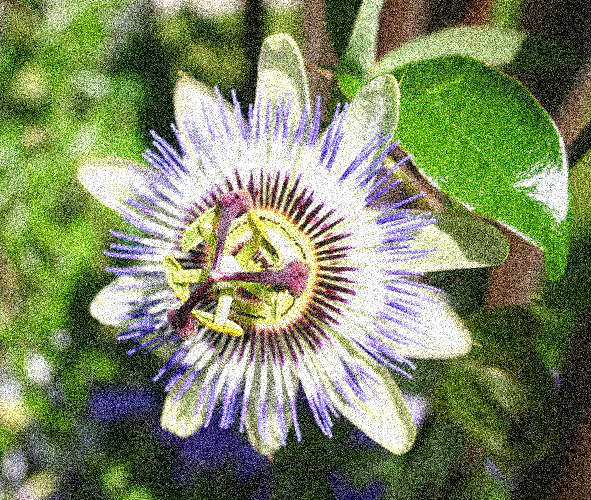

In [ ]:
all_data['flip3'][0]

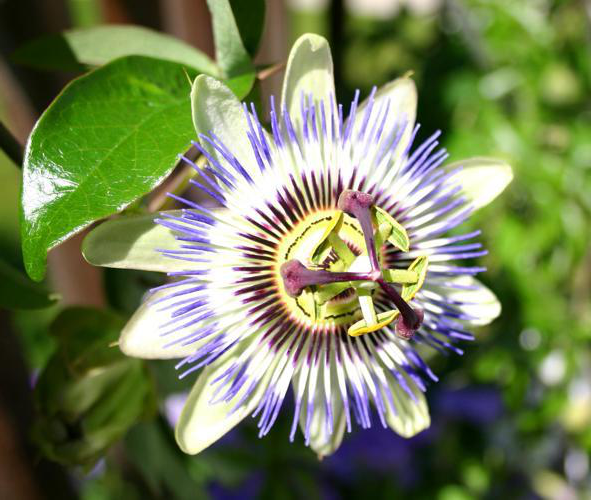

In [ ]:
all_data['flip1'][0]

In [ ]:
train_data.explore()

/usr/local/lib/python3.7/dist-packages/turicreate/visualization/_plot.py:461: UserWarning: Displaying only the first 100 rows.
  warnings.warn("Displaying only the first {} rows.".format(maximum_rows))


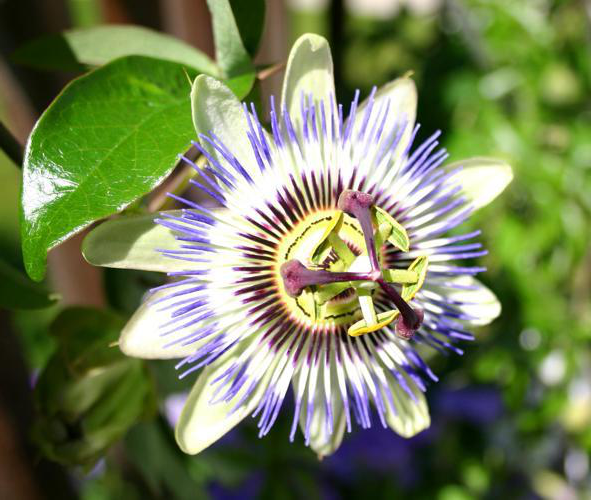

In [ ]:
RAW_FORMAT = 2
hflip= iaa.Fliplr(p=1.0)
train_data['flip1'] = train_data['image'].apply(lambda x: hflip.augment_image(x.pixel_data))
input_hf=train_data['flip1'][0].astype(np.uint8)
input_hf_image = tc.Image(_image_data=input_hf.tobytes(), 
         _width=input_hf.shape[1], 
         _height=input_hf.shape[0], 
         _channels=input_hf.shape[2], 
         _format_enum=RAW_FORMAT, 
         _image_data_size=input_hf.size)
input_hf_image

In [ ]:
contrast=iaa.GammaContrast((0.5, 2.0))
all_data['flip4'] = all_data['image'].apply(lambda x: tc.Image(_image_data=contrast.augment_image(x.pixel_data).astype(np.uint8).tobytes(), 
                                                                   _width=contrast.augment_image(x.pixel_data).astype(np.uint8).shape[1], 
                                                                   _height=contrast.augment_image(x.pixel_data).astype(np.uint8).shape[0], 
                                                                   _channels=contrast.augment_image(x.pixel_data).astype(np.uint8).shape[2], 
                                                                   _format_enum=RAW_FORMAT, 
                                                                   _image_data_size=contrast.augment_image(x.pixel_data).astype(np.uint8).size))

contrast_sig = iaa.SigmoidContrast(gain=(5, 10), cutoff=(0.4, 0.6))
all_data['flip5'] = all_data['image'].apply(lambda x: tc.Image(_image_data=contrast_sig.augment_image(x.pixel_data).astype(np.uint8).tobytes(), 
                                                                   _width=contrast_sig.augment_image(x.pixel_data).astype(np.uint8).shape[1], 
                                                                   _height=contrast_sig.augment_image(x.pixel_data).astype(np.uint8).shape[0], 
                                                                   _channels=contrast_sig.augment_image(x.pixel_data).astype(np.uint8).shape[2], 
                                                                   _format_enum=RAW_FORMAT, 
                                                                   _image_data_size=contrast_sig.augment_image(x.pixel_data).astype(np.uint8).size))

contrast_lin = iaa.LinearContrast((0.6, 0.4))
all_data['flip6'] = all_data['image'].apply(lambda x: tc.Image(_image_data=contrast_lin.augment_image(x.pixel_data).astype(np.uint8).tobytes(), 
                                                                   _width=contrast_lin.augment_image(x.pixel_data).astype(np.uint8).shape[1], 
                                                                   _height=contrast_lin.augment_image(x.pixel_data).astype(np.uint8).shape[0], 
                                                                   _channels=contrast_lin.augment_image(x.pixel_data).astype(np.uint8).shape[2], 
                                                                   _format_enum=RAW_FORMAT, 
                                                                   _image_data_size=contrast_lin.augment_image(x.pixel_data).astype(np.uint8).size))



all_data.materialize()